# Py: Socio-Economic Index Construction
This notebook was originally created by Andres Villegas Ramirez for the Data Analytics Applications subject, as *Case study 1 - The Socio-Economic Indexes for Areas*  in the *DAA M06 Unsupervised learning* module.

Data Analytics Applications is a Fellowship Applications (Module 3) subject with the Actuaries Institute that aims to teach students how to apply a range of data analytics skills, such as neural networks, natural language processing, unsupervised learning and optimisation techniques, together with their professional judgement, to solve a variety of complex and challenging business problems. The business problems used as examples in this subject are drawn from a wide range of industries.

Find out more about the course [here](https://www.actuaries.asn.au/education-program/fellowship/subjects-and-syllabus/data-analytics-applications-subject).

### Purpose:
This case study demonstrates the use of principal component analysis (PCA) in the construction of an index to rank the socio-economic status of different geographical areas within a country (in this instance, Australia). Such index can be useful to identify areas that require funding or services, or as input for research into the relationship between socio-economic conditions and other outcomes in different areas.

In Australia, the Australian Bureau of Statistics (ABS) produces four of such indexes, referred to as the Socio-Economic Indexes for Areas (SEIFA). SEIFA ranks areas in Australia based on their relative socio-economic advantage and disadvantage.

This notebook replicates the methodology adopted by the ABS in constructing one of these indexes - **Index of Economic Resources, or IER** by Statistical Area 1 ([**SA1**](https://www.abs.gov.au/ausstats/abs@.nsf/Lookup/by%20Subject/1270.0.55.001~July%202016~Main%20Features~Statistical%20Area%20Level%201%20(SA1)~10013#:~:text=Statistical%20Areas%20Level%201%20(SA1,Standard%20(ASGS)%20Main%20Structure.))).


### This Jupyter notebook is organised into the following sections:

* **[Section 1:](#1-load-packages)** Load required packages
* **[Section 2:](#2-define-functions)** Define a function for plotting
* **[Section 3:](#3-import-and-transform-data)** Import and transform data
* **[Section 4:](#4-modelling)** Apply Principal Component Analysis and calibrate SEIFA score
* **[Section 5:](#5-reconcile-with-abs-publication)** Check against ABS publication

### 1. Load Packages


In [47]:
# Import required Python packages

#Dataframe operations
import pandas as pd 

#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Plotting
import matplotlib.pyplot as plt


<a id='Section_2'></a>

### 2. Define Functions


In [48]:

# Define a function to obtain the explained variances from the PCA features.

## Good practice to define functions upfront.

def plot_explained_variances(pca):

    exp_var_pca = pca.explained_variance_ratio_

    plt.bar(range(1, len(exp_var_pca) + 1), exp_var_pca, alpha = 0.5, align = 'center',
            label='Individual explained variance',color='dodgerblue')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

### 3. Import and Transform Data


In [49]:
# Import data
## File 1: Standardised socio-economic variables published by the ABS (i.e. input to the PCA model)
## File 2: IER scores by Statistical Area 1 published by the ABS


infolder = 'https://actuariesinstitute.github.io/cookbook/_static/daa_datasets/'

file1 = 'standardised_variables_seifa_2021_cut.csv'
file2 = 'IER_2021.csv'

data1 = pd.read_csv(infolder + file1)
data2 = pd.read_csv(infolder + file2)


In [50]:
# Inspect data

## These are numerical features (e.g. % corresponding to a variable, see dictionary below) which are standardised

data1.head()


SA1_2021   INC_LOW  INC_HIGH  ATSCHOOL     ATUNI  CERTIFICATE    DEGREE  \
0  10102100701  0.031160 -0.451226 -0.307998 -0.611843     2.110423 -0.792820   
1  10102100702 -0.745478  0.235597  0.309750 -0.718416     0.795239 -0.138695   
2  10102100703  0.207462 -0.333816  0.648522 -0.373289     0.143017  0.089753   
3  10102100704  0.383411 -0.417133 -1.082034 -0.887458    -0.308372  0.417513   
4  10102100705  0.334499  0.256282 -1.018268 -0.396676     0.235498 -0.072269   

    DIPLOMA  NOYR12ORHIGHER     NOEDU  ...   HIGHCAR     NOCAR  DISABILITYU70  \
0  1.399224        0.039552 -0.494326  ...  1.124942 -0.361674       1.160679   
1  1.122862       -0.328068 -0.494326  ...  2.165534 -0.737816      -1.371078   
2 -0.024178       -0.148292 -0.494326  ... -0.474119 -0.425240      -1.064640   
3 -0.160872        0.083635  0.108973  ... -0.407742 -0.528653       0.038035   
4 -0.227208        0.356362 -0.494326  ... -0.135464 -0.477578       0.056221   

   ENGLISHPOOR  ONEPARENT  SEP_DIVORCED  UNINCORP  CHILDJOBLESS  \
0    -0.628432  -0.087881     -0.046096  0.533110     -0.797863   
1    -0.628432  -1.513208     -0.216841  1.846095     -0.797863   
2    -0.628432   0.078716      0.963607  0.486319     -0.335393   
3    -0.628432   0.949299      1.482164  0.808398      0.554274   
4    -0.628432  -1.048310      1.253986  0.795448     -0.116016   

   MORTGAGEOVER30  RENTOVER30  
0        0.427678   -1.208146  
1        0.322564   -1.208146  
2       -0.486090   -0.029516  
3       -0.156349   -0.423796  
4       -0.297469   -0.292223  

[5 rows x 45 columns]

#### Variable dictionary

| Variable name | Variable description |
|---------------|----------------------|
| INC_LOW | Per cent of people living in households with stated annual household equivalised income between $1 and $25,999 (approx. 1st and 2nd deciles) |
| LOWRENT | Per cent of occupied private dwellings paying rent less than $250 per week (excluding $0 per week) |
| NOCAR | Per cent of occupied private dwellings with no cars |
| LONE | Per cent of occupied private dwellings who are lone person occupied private dwellings |
| ONEPARENT | Per cent of one parent families with dependent offspring only |
| OVERCROWD | Per cent of occupied private dwellings requiring one or more extra bedrooms (based on Canadian National Occupancy Standard) |
| UNEMPLOYED_IER | Per cent of people aged 15 years and over who are unemployed |
| GROUP | Per cent of occupied private dwellings who are group occupied private dwellings |
| OWNING | Per cent of occupied private dwellings owning dwelling without a mortgage |
| UNINCORP | Per cent of dwellings with at least one person who is an owner of an unincorporated enterprise |
| INC_HIGH | Per cent of people with stated annual household equivalised income greater than $91,000 |
| HIGHMORTGAGE | Per cent of occupied private dwellings paying mortgage greater than $2,800 per month |
| MORTGAGE | Per cent of occupied private dwellings owning dwelling (with a mortgage) |
| HIGHBED | Per cent of occupied private dwellings with four or more bedrooms |


In [51]:
# Inspect data

## IER scored published based on 2021 Census data collection

data2.head()

SA1_2021     IER_2021
0  10102100701  1023.037282
1  10102100702  1088.576036
2  10102100703  986.1022032
3  10102100704  965.4964701
4  10102100705  1013.432808

In [52]:
# Select variables ABS uses to calibrate the IER (per their methodology)

variable_IER = [
    'SA1_2021',
    'INC_LOW',
    'LOWRENT',
    'NOCAR',
    'LONE',
    'ONEPARENT',
    'OVERCROWD',
    'UNEMPLOYED_IER',
    'GROUP',
    'OWNING',
    'UNINCORP',
    'INC_HIGH',
    'HIGHMORTGAGE',
    'MORTGAGE',
    'HIGHBED'

]

data1_IER = data1[variable_IER]


In [53]:
# Inspect data type for these variables

data1_IER.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59430 entries, 0 to 59429
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SA1_2021        59430 non-null  int64  
 1   INC_LOW         59427 non-null  float64
 2   LOWRENT         59400 non-null  float64
 3   NOCAR           59422 non-null  float64
 4   LONE            59430 non-null  float64
 5   ONEPARENT       59319 non-null  float64
 6   OVERCROWD       59417 non-null  float64
 7   UNEMPLOYED_IER  59429 non-null  float64
 8   GROUP           59430 non-null  float64
 9   OWNING          59423 non-null  float64
 10  UNINCORP        59430 non-null  float64
 11  INC_HIGH        59427 non-null  float64
 12  HIGHMORTGAGE    59400 non-null  float64
 13  MORTGAGE        59423 non-null  float64
 14  HIGHBED         59422 non-null  float64
dtypes: float64(14), int64(1)
memory usage: 6.8 MB


In [54]:
# Remove rows with missing values

print(data1_IER.isna().sum())
data1_IER_dropna = data1_IER.dropna()

SA1_2021            0
INC_LOW             3
LOWRENT            30
NOCAR               8
LONE                0
ONEPARENT         111
OVERCROWD          13
UNEMPLOYED_IER      1
GROUP               0
OWNING              7
UNINCORP            0
INC_HIGH            3
HIGHMORTGAGE       30
MORTGAGE            7
HIGHBED             8
dtype: int64


In [55]:

# Standardise data for PCA

## Select data from column 2 onwards (inclusive). First column is SA1 ID.
pca_data = data1_IER_dropna.iloc[:, 1:]

## Standardise these columns to mean 0 and variance 1
sc = StandardScaler()
sc.fit(pca_data)
pca_data = sc.transform(pca_data)

## Inspect outputs, each row represents a SA1 

print(data1_IER_dropna[50:55])
print(pca_data[50:55])


       SA1_2021   INC_LOW   LOWRENT     NOCAR      LONE  ONEPARENT  OVERCROWD  \
50  10102100921 -0.694978 -0.149470  0.026395  2.161618   0.016894   0.614584   
51  10102100923 -0.399570 -0.230663 -0.392438  0.346039   0.479932  -0.327006   
53  10102100925 -1.184584 -0.369694 -0.584525  1.995606   1.010923   0.163947   
54  10102100926 -0.755434  0.636737  0.194704  1.770099  -0.418760   0.828480   
55  10102100927 -0.534872 -0.113768 -0.443336 -0.248692  -0.929502   0.042116   

    UNEMPLOYED_IER     GROUP    OWNING  UNINCORP  INC_HIGH  HIGHMORTGAGE  \
50       -0.768433 -0.298797 -1.379936 -1.409706  0.565708     -0.711816   
51       -0.502225 -0.435782 -0.068099 -1.078581  0.417556     -0.309550   
53        0.393123  0.492720 -1.552475 -0.869567  0.401089     -0.914661   
54        0.562322  1.018832 -1.283807 -0.853606 -0.501616     -0.914661   
55       -0.591322  0.001803 -0.652794 -0.622710  0.248079      0.145029   

    MORTGAGE   HIGHBED  
50 -0.075949 -1.407022  
51  0.

### 4. Modelling
This section performs the PCA to recreate the ABS's IER Index.

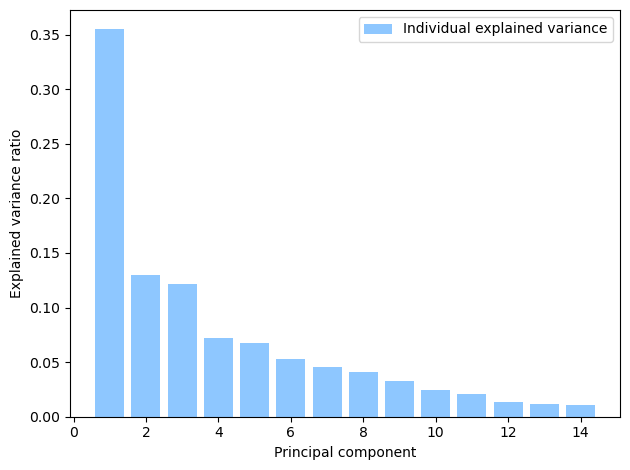

In [56]:

# Initiate the PCA.
pca = PCA()

# Fit the PCA model to determine the transformed features.
## It took 2 lines to fit the PCA model.
pca.fit_transform(pca_data)

# Plot variance explained by principal components
plot_explained_variances(pca)

Principal component 1 (PC1) explains over 30% of the variance in the data. PC1 is used as the basis of calculating the IER. 

In [57]:
pca_data[0]

array([ 3.21902216e-02, -1.95351071e-01, -3.62869762e-01,  3.59364682e-01,
       -8.80285299e-02,  1.99924572e-01, -6.52078395e-01, -9.12914962e-01,
        1.26794033e+00,  5.39782081e-01, -4.52416487e-01, -3.17209382e-01,
        2.45495526e-01,  4.39423025e-04])

In [58]:
# Reverse sign (per ABS methodology)

pca_data_transformed = -1.0*pca.fit_transform(pca_data)


In [59]:

# Extract first principal component in a dataframe
pca1 = pd.DataFrame(pca_data_transformed[:, 0], columns = ['IER_2021'])

# Attach SA1 ID to
IER_S1 = pd.concat([data1_IER_dropna['SA1_2021'].reset_index(drop = True), pca1]
                    , axis=1)

print(IER_S1.head(1))


      SA1_2021  IER_2021
0  10102100701  0.517295


In [60]:
# Calculation from first principal
## Sign implies how each variable contributes to a score
## Reverse sign to make it more comprehensive

component_df = pd.DataFrame({
    'Variable': data1_IER.columns[1:],
    'PC1 Loading': -1.0 * pca.components_[0],
    'First SA1': pca_data[0]
})

print(component_df)


raw_score_first_SA1 = (component_df['PC1 Loading'] * component_df['First SA1']).sum()


print('\n')
print('\n')
print(raw_score_first_SA1)

          Variable  PC1 Loading  First SA1
0          INC_LOW    -0.327920   0.032190
1          LOWRENT    -0.320014  -0.195351
2            NOCAR    -0.316516  -0.362870
3             LONE    -0.307799   0.359365
4        ONEPARENT    -0.243785  -0.088029
5        OVERCROWD    -0.231555   0.199925
6   UNEMPLOYED_IER    -0.217694  -0.652078
7            GROUP    -0.175738  -0.912915
8           OWNING     0.152087   1.267940
9         UNINCORP     0.211586   0.539782
10        INC_HIGH     0.233597  -0.452416
11    HIGHMORTGAGE     0.285636  -0.317209
12        MORTGAGE     0.295868   0.245496
13         HIGHBED     0.334995   0.000439




0.5172947202278048


#### A recap of the dataframe operations for transforming raw data to principal components

| Dataframe name | Operations |
|---------------|----------------------|
data1 | Raw data we'll be using to replicate the SEIFA IER score, numercial features (%) | 
data1_IER | Select features for determining IER from data1 | 
data1_IER_dropna | Remove missing values in data1_IER | 
pca_data | Standardise features in data1_IER_dropna to mean 0 and s.d. 1, used to perform PCA | 
pca | Output of PCA, Principal Components | 
pca_data_transformed | Reverse sign in pca | 
pca1 | Extract first principal component from pca_data_transformed | 
IER_S1 | Attach SA1 identifier to pca1, compared to dataframe ABS_IER_S1 which is the published data | 


In [61]:
# Standardise calibrated IER scores to mean of 1,000 and standard deviation of 100 (per ABS methodology)

IER_S1['IER_recreated'] = (IER_S1['IER_2021']/IER_S1['IER_2021'].std())*100+1000

print(IER_S1.tail())


          SA1_2021  IER_2021  IER_recreated
59298  90104100401  0.022187    1000.995399
59299  90104100402 -0.055935     997.490510
59300  90104100403 -0.785740     964.748521
59301  90104100404 -1.702813     923.604956
59302  90104100407 -0.116936     994.753789


### 5. Reconcile with ABS publication

In [62]:

# Extract first two columns in the desired data type

ABS_IER_S1 = data2.iloc[:, [0, 1]]

ABS_IER_S1['IER_2021'] = pd.to_numeric(ABS_IER_S1['IER_2021'],
                                        errors='coerce')
ABS_IER_S1['SA1_2021'] = pd.to_numeric(ABS_IER_S1['SA1_2021'],
                                        errors='coerce', downcast = 'integer')


print(ABS_IER_S1.info())
print('\n')
print(ABS_IER_S1.head())
print('\n')
print(ABS_IER_S1.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59421 entries, 0 to 59420
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SA1_2021  59421 non-null  int64  
 1   IER_2021  59303 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 928.6 KB
None


      SA1_2021     IER_2021
0  10102100701  1023.037282
1  10102100702  1088.576036
2  10102100703   986.102203
3  10102100704   965.496470
4  10102100705  1013.432808


SA1_2021      0
IER_2021    118
dtype: int64


In [63]:
## Remove rows with missing value

print(ABS_IER_S1.isna().sum())
ABS_IER_S1_dropna = ABS_IER_S1.dropna()

print(len(data1_IER_dropna))
print(len(ABS_IER_S1_dropna))

SA1_2021      0
IER_2021    118
dtype: int64
59303
59303


In [64]:
# Merge the recreated with the published data for reconciliation 1 - histograms

join = pd.merge(ABS_IER_S1_dropna, data1_IER_dropna, how = 'left', on = 'SA1_2021')


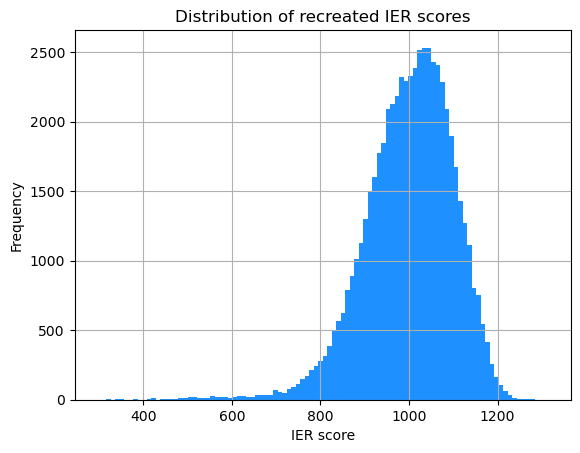

In [65]:
# Plot histogram of calibrated IER scores

IER_S1.hist(column='IER_recreated', bins=100, color='dodgerblue')
plt.title('Distribution of recreated IER scores')
plt.xlabel('IER score')
plt.ylabel('Frequency')

plt.show()


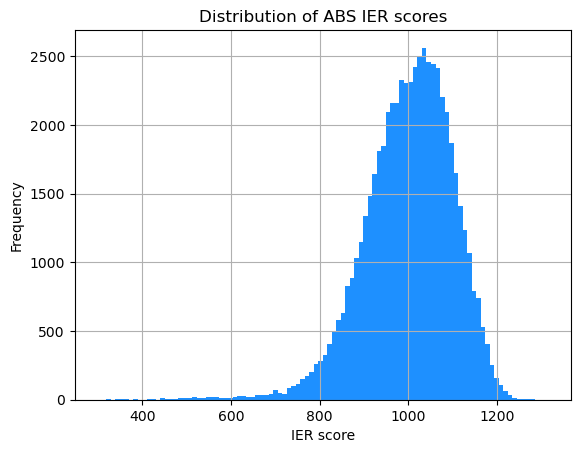

In [66]:
# Plot histogram of publisehd IER scores

ABS_IER_S1_dropna.hist(column='IER_2021', bins=100, color='dodgerblue')
plt.title('Distribution of ABS IER scores')
plt.xlabel('IER score')
plt.ylabel('Frequency')

plt.show()

ABS_IER_S1_dropna.to_csv('check_ABS_IER_S1_dropna.csv')

The two histograms are very similar in shape!

In [67]:
# Extract columns we need

IER_S1_reduce = IER_S1[['SA1_2021', 'IER_recreated']]

In [68]:
# Merge the recreated with the published data for reconciliation 2 - scatter plot

IER_join = pd.merge(ABS_IER_S1_dropna, IER_S1_reduce, how = 'left', on = 'SA1_2021')

print(IER_join.tail())


          SA1_2021     IER_2021  IER_recreated
59298  90104100401  1000.369129    1000.995399
59299  90104100402   996.979765     997.490510
59300  90104100403   964.139169     964.748521
59301  90104100404   923.050144     923.604956
59302  90104100407   994.377312     994.753789


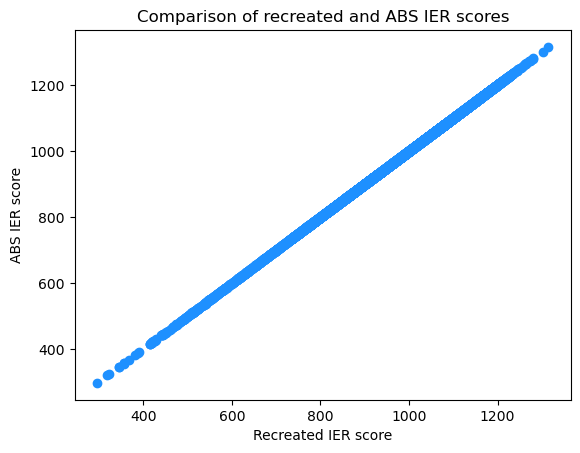

In [69]:
# Plot calibrated score vs. published score

plt.scatter('IER_recreated', 'IER_2021', data = IER_join, color='dodgerblue')
plt.title('Comparison of recreated and ABS IER scores')
plt.xlabel('Recreated IER score')
plt.ylabel('ABS IER score')

plt.show()


The above scatter plot shows that the two sets of indexes are very closely aligned.